In [1]:
import pandas as pd
import pydicom
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')

In [2]:
# Function to load DICOM images and resize them to (299, 299)
def load_dicom_image(image_path, target_size=(299, 299)):  # Resize to 299x299 for InceptionV3
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)  # Resize to 299x299
    
    # Normalize pixel values
    image_normalized = image_resized / np.max(image_resized)

    # Convert grayscale to 3 channels by replicating the grayscale image
    image_rgb = np.stack([image_normalized] * 3, axis=-1)  # Replicate across 3 channels
    return image_rgb

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

In [3]:
# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [4]:
images.shape

(2374, 299, 299, 3)

use inceptionV3

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten

# Load InceptionV3 for feature extraction, without the final classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the extracted features
    Flatten()  # Flatten the features to a 1D vector
])

# Extract features from the entire dataset
features = feature_extractor.predict(images)

75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step


In [31]:
from sklearn.svm import SVC
# Now split the extracted features into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [32]:
classifier = SVC(kernel='linear',C= 1.0, gamma= 1.0)
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.66       247
           1       0.63      0.66      0.65       228

    accuracy                           0.65       475
   macro avg       0.65      0.65      0.65       475
weighted avg       0.65      0.65      0.65       475



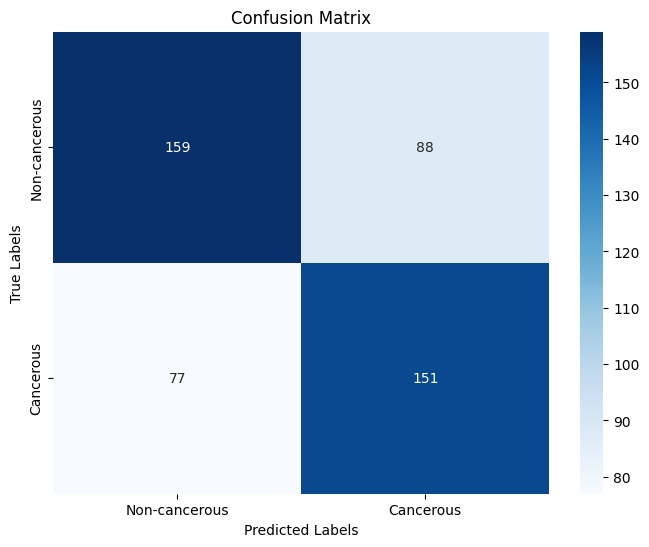

In [34]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [35]:
import joblib

# Save the trained model to a file
joblib.dump(svm_classifier, 'Models/inception_lda_svm_model.pkl')  # You can choose your desired filename

['Models/inception_lda_svm_model.pkl']

In [20]:
# Load the saved model from the file
svm_classifier_loaded = joblib.load('Models/inception_lda_svm_model.pkl')

# Now you can use the loaded model to make predictions, etc.
y_test_pred = svm_classifier_loaded.predict(X_test)

## INTRODUCE LDA

In [36]:
# Step 2: Apply LDA (or other transformation) only on the training data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
X_train_lda = lda.fit_transform(X_train, y_train)  # Fit and transform the training data

# Step 3: Transform the test data using the same LDA transformation (no fitting here)
X_test_lda = lda.transform(X_test)  # Only transform the test data

# Step 4: Train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, gamma=1.0)
svm_classifier.fit(X_train_lda, y_train)

SVC(gamma=1.0, kernel='linear')

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_test_pred = svm_classifier.predict(X_test_lda)

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       247
           1       0.49      0.51      0.50       228

    accuracy                           0.51       475
   macro avg       0.51      0.51      0.51       475
weighted avg       0.51      0.51      0.51       475



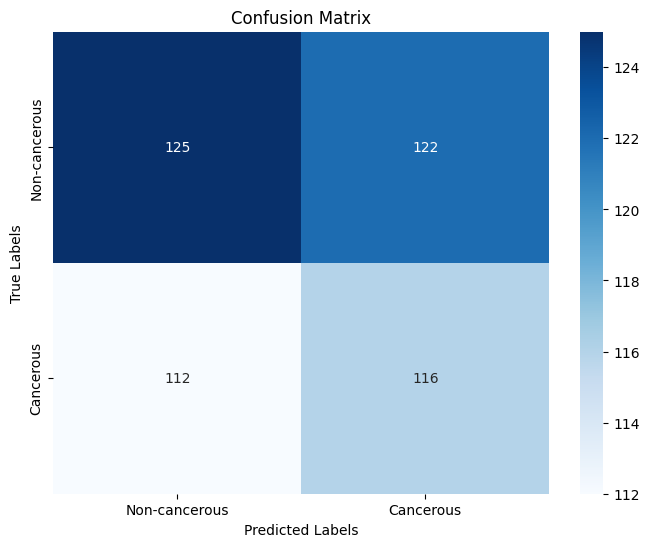

In [38]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Usig PCA after splitting

In [43]:
from sklearn.decomposition import PCA

# Step 2: Apply PCA only on the training data
pca = PCA(n_components=0.95)  # Keep 95% of the variance (you can adjust the number of components)
X_train_pca = pca.fit_transform(X_train)  # Fit and transform the training data

# Step 3: Transform the test data using the same PCA transformation (no fitting here)
X_test_pca = pca.transform(X_test)  # Only transform the test data

In [44]:
# Step 4: Train the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, gamma=1.0)
svm_classifier.fit(X_train_pca, y_train)

SVC(gamma=1.0, kernel='linear')

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_test_pred = svm_classifier.predict(X_test_pca)

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       247
           1       0.64      0.68      0.66       228

    accuracy                           0.66       475
   macro avg       0.66      0.66      0.66       475
weighted avg       0.66      0.66      0.66       475



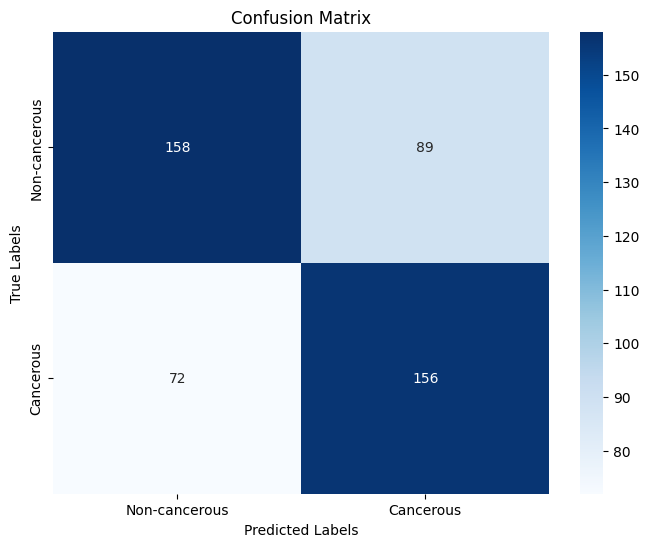

In [46]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()